## Magic
Paper: https://www.sciencedirect.com/science/article/pii/S0092867418307244?via%3Dihub

In [1]:
import magic
import scprep
import os
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pickle

Matplotlib created a temporary config/cache directory at /tmp/pbs.4362233.pbsha.ib.sockeye/matplotlib-y5e5xkqt because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
paths = {
    'cite': '/arc/project/st-jiaruid-1/shenoy/data/multiome-sparse-rc/train_cite_inputs_raw_values.sparse.npz',
    'cite_cols': '/arc/project/st-jiaruid-1/shenoy/data/multiome-sparse-rc/train_cite_inputs_raw_idxcol.npz', 
    'multiome': '/arc/project/st-jiaruid-1/shenoy/data/multiome-sparse-rc/train_multi_inputs_raw_values.sparse.npz',
    'multiome_cols': '/arc/project/st-jiaruid-1/shenoy/data/multiome-sparse-rc/train_multi_inputs_raw_idxcol.npz',
}

In [3]:
modality = 'cite'

In [4]:
path = paths[modality]
assert os.path.exists(path)

In [ ]:
df = pd.DataFrame.sparse.from_spmatrix(
    sparse.load_npz(path), 
    columns=list(np.load(paths[f'{modality}_cols'], allow_pickle=True)['columns'])
)

In [ ]:
df.head()

In [ ]:
def perform(
    df,
    modality,
    filter_empty_genes = True,
    normalize='batch_mean_center', 
    rescale=None, 
    save_dir='/scratch/st-jiaruid-1/shenoy/data/'
):
    print (f'Filter Empty Genes: {filter_empty_genes}')
    if filter_empty_genes:
        df = scprep.filter.filter_empty_genes(df)
    
    print (f'Normalizing using : {normalize}')
    if normalize == 'batch_mean_center':
        df = df.sparse.to_dense()
        df = scprep.normalize.batch_mean_center(df)
    elif normalize == 'library_size_normalize':
        if rescale is None:
            df = scprep.normalize.library_size_normalize(df)
        else:
            df = scprep.normalize.library_size_normalize(df, rescale=rescale)
    
    print (f'Performing SVD to 128 dimensions')
    svd = TruncatedSVD(n_components=128)
    df = svd.fit_transform(df)
    
    # save at save_dir
    filename = f'{modality}_filtergenes_{filter_empty_genes}_{normalize}_rescale{str(rescale)}_128.pkl'
    path = os.path.join(save_dir, filename)
    print (f'Saving Now @ {path}')
    with open(path, 'wb') as f:
        pickle.dump(df, f)

In [ ]:
perform(
    df, 
    modality,
    filter_empty_genes = True,
    normalize='batch_mean_center', 
    rescale=None,   
)
perform(
    df, 
    modality,    
    filter_empty_genes = True,
    normalize='library_size_normalize', 
    rescale=None,   
)
perform(
    df, 
    modality,    
    filter_empty_genes = True,
    normalize='library_size_normalize', 
    rescale='mean',   
)
perform(
    df, 
    modality,    
    filter_empty_genes = True,
    normalize='library_size_normalize', 
    rescale='median',   
)

#### Initial Analysis with ScPrep

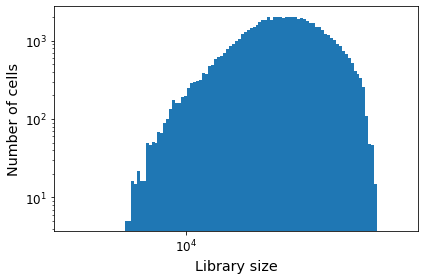

In [7]:
# scprep.plot.plot_library_size(df)
# plt.show()
# scprep.plot.plot_gene_set_expression(df)
# plt.show()

#### Try different Normalization
1) Batch Mean Center <br>
2) Library Size Normalize

In [9]:
dense_df = df.sparse.to_dense()
del df

In [10]:
df = scprep.normalize.batch_mean_center(dense_df)

/scratch/st-jiaruid-1/shenoy/ml-gpu/lib/python3.6/site-packages/scprep/select.py:370: UserWarning: No selection conditions provided. Returning all columns.
  "No selection conditions provided. Returning all columns.", UserWarning


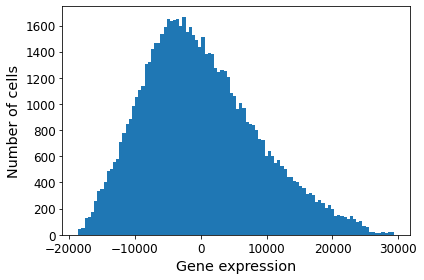

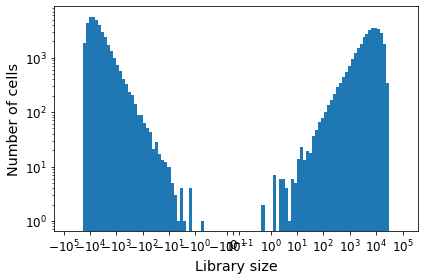

In [11]:
scprep.plot.plot_gene_set_expression(df)
plt.show()
scprep.plot.plot_library_size(df)
plt.show()

In [16]:
df = scprep.normalize.library_size_normalize(dense_df, rescale='median')

/scratch/st-jiaruid-1/shenoy/ml-gpu/lib/python3.6/site-packages/scprep/select.py:370: UserWarning: No selection conditions provided. Returning all columns.
  "No selection conditions provided. Returning all columns.", UserWarning


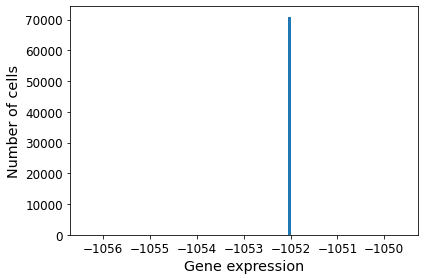

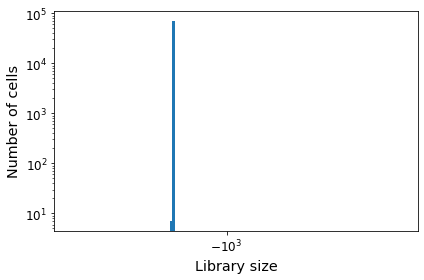

In [17]:
scprep.plot.plot_gene_set_expression(df)
plt.show()
scprep.plot.plot_library_size(df)
plt.show()

#### dimensionality reduction

In [20]:
svd = TruncatedSVD(n_components=128)

In [21]:
df_final = svd.fit_transform(df)